In [3]:
#import jax and other libraries for computation
import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util
import jax.random as random
import numpy as np
#for visulization
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
# import AdoptODE
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
#import the MSD mechanics
from HelperAndMechanics import *
import h5py

In [4]:
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_05_uvx.h5', 'r') as f:
    v = f['v'][:100]
    u = f['u'][:100]
    T = f['T'][:100]
    x = f['x'][:100]
    f.close()
print('max_v = ',np.max(v),'\nmax_u =',np.max(u),' \nmax_T = ',np.max(T))
N = T.shape[0]


max_v =  2.1436 
max_u = 0.975221  
max_T =  2.68513


In [5]:
def define_NavierCauchy(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']

    def gen_params():
        return {key:value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for key,value in kwargs_sys['params_true'].items()}, {}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'U':kwargs_sys['U0'],'V':kwargs_sys['V0']}
    
    # electric model
    @jit
    def kernel(spacing):
        kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (spacing* spacing * 6)
        return kernel
    @jit
    def laplace(f,spacing):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel(spacing), mode='valid')
    @jit
    def epsilon(u,v,params):
        return params['epsilon_0']+params['mu_1']*v/(u+params['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))    

    @jit
    def gradient(field, dx):
        """Compute the gradient of a scalar field field(x, y) in 2D."""
        grad_x = jnp.gradient(field, axis=0) / dx  
        grad_y = jnp.gradient(field, axis=1) / dx  
        return jnp.stack([grad_x, grad_y], axis=-1)  # Shape: (N, N, 2)
    # Define Laplacian operator
    @jit
    def laplacian(U,dx):
        return (
            -4 * U
            + jnp.roll(U, shift=1, axis=0) + jnp.roll(U, shift=-1, axis=0)
            + jnp.roll(U, shift=1, axis=1) + jnp.roll(U, shift=-1, axis=1)
        ) / dx**2

    # Compute divergence
    @jit
    def divergence(U,dx):
        return jnp.gradient(U[..., 0], axis=0)/dx + jnp.gradient(U[..., 1], axis=1)/dx

    # Compute stress tensor
    @jit
    def stress(U, params):
        div_U = divergence(U,params['dx'])
        return (params['lmbda'] + params['mu']) * gradient(div_U,params['dx']) + params['mu'] * laplacian(U,params['dx'])
    #Full Model
    @jit
    def eom(y, t, params, iparams, exparams):
        par=params
        u=y['u']
        v=y['v']
        T=y['T']
        U=y['U']
        V=y['V']

        dudt = par['D']*laplace(u,par['spacing'])-(par['k'])*u*(u-par['a'])*(u-1) - u*v
        dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
        dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
        dU = V 
        dV = (1 / par['rho']) * (stress(U,par) + gradient(T,par['dx']))  # Update velocity
        
        return {'u':dudt, 'v':dvdt, 'T':dTdt, 'U':zero_out_edgesFD(dU), 'V':zero_out_edgesFD(dV)}
    @jit
    def loss(ys, params, iparams, exparams, targets):
        # u = ys['u']
        # u_target = targets['u']
        U = ys['U']
        U_target = targets['U']
        V = ys['V']
        V_target = targets['V']
        
        return  jnp.nanmean((U - U_target)**2 + (V-V_target)**2) #jnp.nanmean((u - u_target)**2) +
            
    return eom, loss, gen_params, gen_y0, {}




In [57]:
import jax
import jax.numpy as jnp
from jax.scipy.sparse.linalg import cg

# Grid size and spacing
nx, ny = 100,100
dx = 1 / nx
# Material properties (Lamé parameters)
lam, mu = 1.25, 1.0

@jax.jit
def active_stress(x, y):
    """Example active stress field T_a(x, y)."""
    return jnp.exp(-((x - 0.5) ** 2 + (y - 0.5) ** 2) / 0.05)

@jax.jit
def compute_force():
    """Computes force as the negative gradient of active stress."""
    x, y = jnp.linspace(0, 1, nx), jnp.linspace(0, 1, ny)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    T_a = T[-1]

    f_x = (jnp.roll(T_a, -1, axis=0) - jnp.roll(T_a, 1, axis=0)) / (2 * dx)
    f_y = (jnp.roll(T_a, -1, axis=1) - jnp.roll(T_a, 1, axis=1)) / (2 * dx)

    return f_x, f_y

@jax.jit
def laplacian(u):
    """Finite-difference Laplacian."""
    return (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) +
            jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) -
            4 * u) / dx**2

@jax.jit
def divergence(ux, uy):
    """Divergence of displacement field using finite differences."""
    return (jnp.roll(ux, -1, axis=0) - jnp.roll(ux, 1, axis=0)) / (2 * dx) + \
           (jnp.roll(uy, -1, axis=1) - jnp.roll(uy, 1, axis=1)) / (2 * dx)

@jax.jit
def gradient(f):
    """Computes gradient of a scalar field f using finite differences."""
    df_dx = (jnp.roll(f, -1, axis=0) - jnp.roll(f, 1, axis=0)) / (2 * dx)
    df_dy = (jnp.roll(f, -1, axis=1) - jnp.roll(f, 1, axis=1)) / (2 * dx)
    return df_dx, df_dy

@jax.jit
def pde_residual(u, f_x, f_y):
    """Computes the PDE residual with active stress force included."""
    ux, uy = u[..., 0], u[..., 1]
    div_u = divergence(ux, uy)

    div_u_x, div_u_y = gradient(div_u)

    px = mu * laplacian(ux) + (lam + mu) * div_u_x + f_x
    py = mu * laplacian(uy) + (lam + mu) * div_u_y + f_y

    return jnp.stack([px, py], axis=-1)

@jax.jit
def solve_elasticity():
    """Solves the Navier-Cauchy equations using CG solver (JIT-compatible)."""
    f_x, f_y = compute_force()
    
    def apply_operator(u_flat):
        """Applies the PDE residual operator in flattened form for CG solver."""
        u = u_flat.reshape(nx, ny, 2)
        residual = pde_residual(u, f_x, f_y)
        return residual.reshape(-1)

    u_init = jnp.zeros((nx, ny, 2))  # Initial guess
    u_sol, _ = cg(apply_operator, u_init.reshape(-1))
    
    return u_sol.reshape(nx, ny, 2)




In [58]:
# Solve for displacement field
u_solution = solve_elasticity()
print("Solved displacement field shape:", u_solution.shape)

Solved displacement field shape: (100, 100, 2)


In [59]:
np.min(u_solution), np.max(u_solution)

(Array(-0.03524522, dtype=float32), Array(0.03727644, dtype=float32))

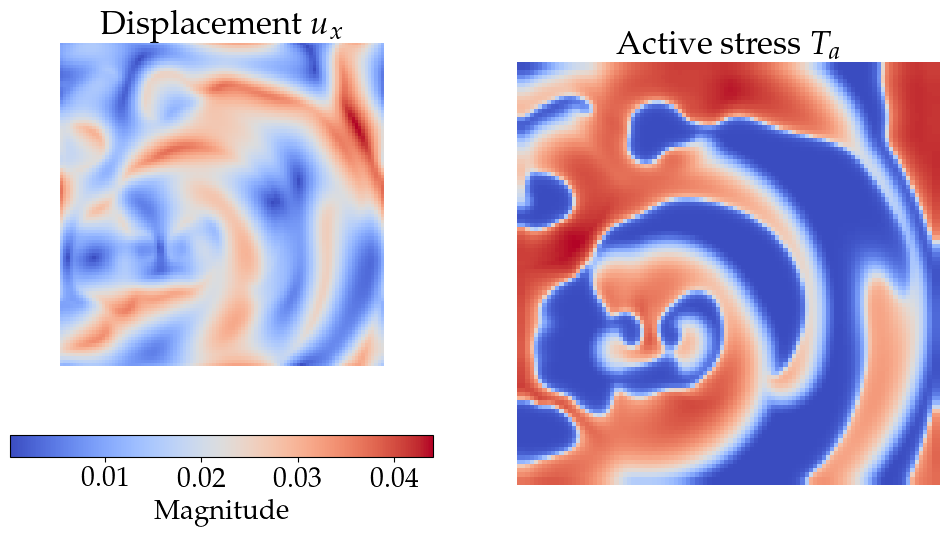

In [60]:
u_abs = jnp.linalg.norm(u_solution, axis=-1)
#plot heatmap of displacement field and active stress field next to each other

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(u_abs, cmap="coolwarm")
axs[0].set_title("Displacement $u_x$")
#plot colorbar
cbar = plt.colorbar(axs[0].imshow(u_abs, cmap="coolwarm"), ax=axs[0], orientation="horizontal")
cbar.set_label("Magnitude")
axs[1].imshow(T[-1], cmap="coolwarm")
axs[1].set_title("Active stress $T_a$")

for ax in axs:
    ax.axis("off")


In [6]:
import jax
import jax.numpy as jnp
from jax.scipy.sparse.linalg import cg

# Grid size and spacing
nx, ny = 50, 50
dx = 1.0 / nx

# Material properties (Lamé parameters)
lam, mu = 1.0, 1.0

# Define Active Stress field (Example: Gaussian)
@jax.jit
def active_stress(x, y):
    """Example active stress field T_a(x, y)."""
    return jnp.exp(-((x - 0.5) ** 2 + (y - 0.5) ** 2) / 0.05)

# Compute force as gradient of T_a
@jax.jit
def gradient(T_a):
    """Computes force as the negative gradient of active stress."""
    x, y = jnp.linspace(0, 1, nx), jnp.linspace(0, 1, ny)
    X, Y = jnp.meshgrid(x, y, indexing="ij")
    
    T_a = active_stress(X, Y)
    
    f_x = -(jnp.roll(T_a, -1, axis=0) - jnp.roll(T_a, 1, axis=0)) / (2 * dx)
    f_y = -(jnp.roll(T_a, -1, axis=1) - jnp.roll(T_a, 1, axis=1)) / (2 * dx)
    
    return f_x, f_y

# Compute f_x, f_y from T_a
f_x, f_y = gradient(T[0])

@jax.jit
def laplacian(u):
    """Finite-difference Laplacian."""
    return (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) +
            jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) -
            4 * u) / dx**2

@jax.jit
def divergence(ux, uy):
    """Divergence of displacement field."""
    return (jnp.roll(ux, -1, axis=0) - ux) / dx + (jnp.roll(uy, -1, axis=1) - uy) / dx

@jax.jit
def pde_residual(u):
    """Computes the PDE residual with active stress."""
    ux, uy = u[..., 0], u[..., 1]
    div_u = divergence(ux, uy)
    
    px = mu * laplacian(ux) + (lam + mu) * jnp.gradient(div_u, axis=0) + f_x
    py = mu * laplacian(uy) + (lam + mu) * jnp.gradient(div_u, axis=1) + f_y
    
    return jnp.stack([px, py], axis=-1)

@jax.jit
def solve_elasticity():
    """Solves the Navier-Cauchy equations using CG solver (JIT-compatible)."""
    u_init = jnp.zeros((nx, ny, 2))  # Initial guess
    u_sol, _ = cg(lambda u: pde_residual(u).reshape(-1), u_init.reshape(-1))
    return u_sol.reshape(nx, ny, 2)

# Solve for displacement field
u_solution = solve_elasticity()
print("Solved displacement field shape:", u_solution.shape)


ValueError: axis 0 is out of bounds for array of dimension 0

In [4]:

"""
    Reads in necessary parameters from config.ini
"""

N,size,params_electric = read_config(['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e','spacing'],mode = 'chaos')
keys_electric =['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e','spacing']

params_true_mechanic = {'lmbda': 1.25, 'mu': 1., 'rho': 1, 'dx':4.}
tol = 0
params_true = dict(zip(keys_electric,params_electric))|params_true_mechanic
print(params_true['k_T'])
params_true['k_T'] = 1.5
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}

length,sampling_rate = 20,500

u0,v0,T0,U0,V0,t_evals = u[0],v[0],T[0],jnp.zeros((100,100,2)),jnp.zeros((100,100,2)),np.linspace(0, params_true['delta_t_e']*sampling_rate*length, length)

kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'par_tol': 0,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0,'U0': U0,'V0': V0}
kwargs_adoptODE = {'epochs': 10,'N_backups': 1,'lr': 1e-3}

3.0


2025-02-27 16:48:48.811837: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.8.61). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
# Setting up a dataset via simulation
Simulation_MSD = simple_simulation(define_NavierCauchy,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE)

In [6]:
#plot u_err = np.abs(u_sim-u_sol)
Ux_sim = Simulation_MSD.ys['U'][0, :, :, :, 0]
Uy_sim = Simulation_MSD.ys['U'][0, :, :, :, 1]
U_tot = jnp.sqrt(Ux_sim**2 + Uy_sim**2)
u_sim = Simulation_MSD.ys['u'][0]
T_sim = Simulation_MSD.ys['T'][0]
print(Ux_sim.shape)
vmin,vmax =  0,1


# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(U_tot[frame], cmap='coolwarm', vmin=Ux_sim.min(), vmax=Ux_sim.max())
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"deformation")
    
    # Plot dA_sim
    im2 = axes[1].matshow(T_sim[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"u-variable")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(Ux_sim[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"U ")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=Ux_sim.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

(20, 100, 100)


IntSlider(value=0, description='Frame', max=19)

Output()